<a href="https://colab.research.google.com/github/njadux/Named-Entity-Recognition-NewsArticles/blob/main/Named_Entity_Recognition_(NER)_from_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detect entities like Person (PER), Location (LOC), Organization (ORG), and Miscellaneous (MISC) inside sentences.

Use two approaches:

- Rule-based (pattern matching with EntityRuler).

- Model-based (pre-trained spaCy models + optional custom training).

Each line of the dataset looks like:

> SOCCER    NN  B-NP  O

>JAPAN      NNP B-NP  B-LOC


Columns:    token POS chunk NER.

In [1]:
# core
!pip install pandas tqdm scikit-learn seqeval

# spaCy and optional transformer model support
!pip install "spacy>=3.0"

# If want the transformer model (higher accuracy, heavier):
!pip install spacy[transformers] transformers

# Download spaCy models (run one or both)
!python -m spacy download en_core_web_sm
# optional (heavy) transformer model — only if spacy[transformers] installed
!python -m spacy download en_core_web_trf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7d5c590f1f2362e5a5faf97e02da513307e890038bb83d30bfd2237664ddd7f9
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.8/795.8 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall:

# Parse CoNLL files → build objects to use

Read the CoNLL Data:
sentences: list of (tokens_list, tags_list)

spacy_data: list of (text, {"entities":[(start,end,label),...]})

sent_info: list of dicts with tokens, tags, offsets — helpful for token-level BIO conversions

In [2]:
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import spacy
from spacy.pipeline import EntityRuler
from spacy.training import Example
from spacy.util import minibatch, compounding
from spacy import displacy
from pathlib import Path
from seqeval.metrics import classification_report, f1_score
import random

> token = parts[0]   # first column is the word itself


> ner   = parts[-1]  # last column is the NER label

In [3]:
def parse_coll_file(path):
  """
    Convert a CoNLL-2003 file into a list of sentences.
    Each sentence is a tuple (tokens, tags):
      tokens: list of words
      tags:   list of BIO NER tags (B-LOC, I-PER, O, etc.)
  """
  # create lists for sentences, toens, and tags
  sentences = []
  tokens, tags = [], []

  # for each line in the file
  for line in Path(path).read_text(encoding="utf-8").splitlines():
    line = line.strip() # clean the line from additional chars

    if not line:
      # Blank line = means endof sentence
      if tokens:
        sentences.append((tokens, tags)) # calling
        tokens, tags = [], []
      continue

    parts = line.split()
    token = parts[0]
    tag = parts[-1]

    tokens.append(token)
    tags.append(tag)


  # Catch the final sentence if file doesn't end with a blank line
  if tokens:
    sentences.append((tokens, tags))

  return sentences

In [4]:
# Load the 3 splits
train_sents = parse_coll_file('/content/train.txt')
valid_sents = parse_coll_file('/content/valid.txt')
test_sents = parse_coll_file('/content/test.txt')

In [5]:
print("Example sentence:", train_sents[10])

Example sentence: (['But', 'Fischler', 'agreed', 'to', 'review', 'his', 'proposal', 'after', 'the', 'EU', "'s", 'standing', 'veterinary', 'committee', ',', 'mational', 'animal', 'health', 'officials', ',', 'questioned', 'if', 'such', 'action', 'was', 'justified', 'as', 'there', 'was', 'only', 'a', 'slight', 'risk', 'to', 'human', 'health', '.'], ['O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


# Convert to spaCy Training Format

Each item in sentences is expected to be (tokens, tags) where

tokens = list of words,

tags = list of BIO tags (e.g. B-PER, I-PER, O).

In order to convert them to spac format


1.   Recreate the full sentence text

Before joining
- tokens = ["New", "York", "is", "great"]

- tags   = ["B-LOC", "I-LOC", "O", "O"]

After joining
> "New York is great"


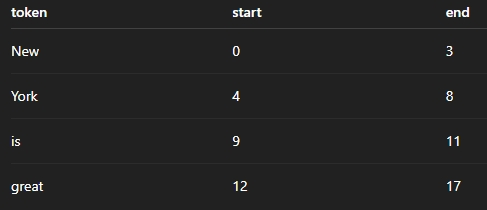










2.   Compute character offsets for each token
> Walk through the tokens to calculate the (start, end)


3.   Identify entities from BIO tags

- Initialize an empty entities list and iterate through the tags:

- If a tag starts with B-, record the entity label (e.g., PER, LOC).

- Continue forward while the next tags start with I-, to capture multi-token entities.

- Use the first token’s start offset and the last token’s end offset to mark the full entity span.

Append (start_char, end_char, label) to entities.

4.   Add the sentence’s data to output

5.  Return the full spaCy-formatted dataset






Example Input :
- tokens = ["New", "York", "City", "is", "big"]
- tags   = ["B-LOC", "I-LOC", "I-LOC", "O", "O"]


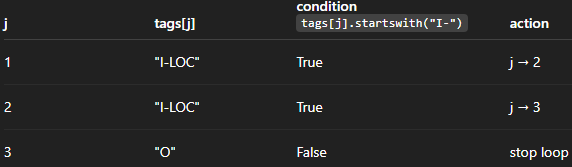

then took the end as the last tag before the loop breaks "City"

> as if : i starts at 0 ("B-LOC" for "New").

> j=3 → stops (because tag is O),

and we deal with tags between them

In [6]:
def build_spacy_format(sentences):
  """
    Turn token/tag pairs into spaCy training data:
    [ ( "sentence text", {"entities":[(start_char,end_char,label),...]} ), ... ]
  """

  spacy_data = []

  for tokens, tags in sentences:
    text = " ".join(tokens)

    # prepare to track the start and end
    offsets = []
    idx = 0

    for token in tokens:
      token_start = idx
      token_end = token_start + len(token)
      offsets.append((token_start, token_end ))

      idx = token_end + 1  # +1 for the space

    # Build a list of entity spans from BIO tags
    entities = []    # hold all named-entity spans


    i = 0
    while i < len(tags):
      if tags[i].startswith("B-"):   # B- tag signals the beginning of an entity [B-LOC]
        label = tags[i][2:]    # e.g. 'LOC'
        # the start of tags indicates to list of tokens e.g. "New"
        start_char = offsets[i][0]  # Extract the entity type (strip B-) and note the starting character index.
        j = i + 1


        # Capture consecutive I- tags for same entity
        while j < len(tags) and tags[j].startswith("I-"):
          j += 1
        end_char = offsets[j-1][1] # the end of tags...

        entities.append((start_char, end_char, label))
        i = j

      else:
        i += 1

  spacy_data.append((text, {"entities": entities})) # Move append outside the loop

  return spacy_data

In [7]:
train_data = build_spacy_format(train_sents)
valid_data = build_spacy_format(valid_sents)
test_data  = build_spacy_format(test_sents)

print(train_data[0])

('Swansea 1 Lincoln 2', {'entities': [(0, 7, 'ORG'), (10, 17, 'ORG')]})


# Explore the Data

Helps you see label distribution (e.g., maybe 40% PER, 30% ORG).

In [8]:
label_counts = Counter()
for _, ann in train_data:
    for _, _, label in ann["entities"]:
        label_counts[label] += 1
print("Entity counts:", label_counts)

Entity counts: Counter({'ORG': 2})


# Rule-Based NER (EntityRuler)

In [9]:
# starting with a blank English pipeline
nlp_rule = spacy.blank("en")
ruler = nlp_rule.add_pipe("entity_ruler")

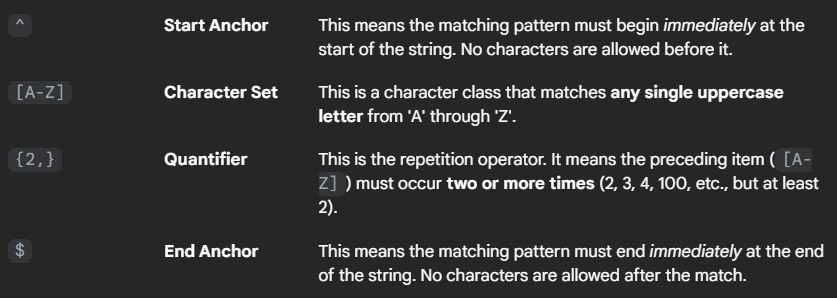

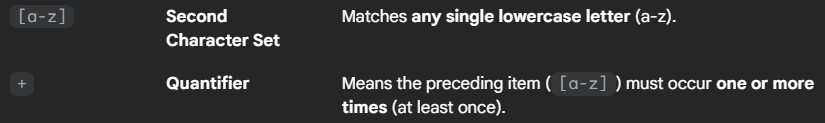

***Examples:***

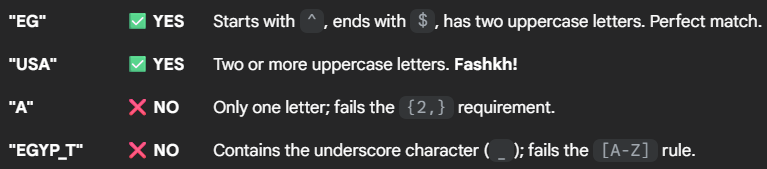

In [11]:
# adding simple rule patterns
patterns = [
    {"label": "ORG", "pattern" : [{"TEXT": {"REGEX": "^[A-Z]{2,}$"}}] },
    {"label": "PERSON", "pattern" : [{"TEXT": {"REGEX": "^[A-Z][a-z]+$"}}] },
    {"label": "LOC", "pattern" : [{"TEXT": {"REGEX": "^[A-Z][a-z]+$"}}, {"TEXT": {"REGEX": "^(City|Town|Country|State)?$"}}] }
]

In [12]:
ruler.add_patterns(patterns)

In [13]:
# testing a random sentence from dataset
sample_text = random.choice(train_data)[0]
doc = nlp_rule(sample_text)

In [18]:
print("Sample Text:\n", sample_text)
print("###########################")
print("\nEntities (Rule-Based):")

for ent in doc.ents:
    print(ent.text,"==>", ent.label_)

Sample Text:
 Swansea 1 Lincoln 2
###########################

Entities (Rule-Based):
Swansea ==> PERSON
Lincoln ==> PERSON


In [20]:
# visualize
displacy.render(doc, style="ent", jupyter=True)

# Model-Based NER (Two SpaCy Models)

>doc_sm: This document was processed using the en_core_web_sm model. The sm stands for small.

 It's fast, light, and gets the job done for basic stuff. Think of it as the quick, no-frills taxi.

>doc_trf: This document was processed using the en_core_web_trf model. The trf stands for transformer.

This model is much bigger, slower, but way more accurate because it uses a complex, state-of-the-art transformer architecture (like BERT). Think of it as the fancy, super-accurate limousine.

In [21]:
nlp_sm = spacy.load("en_core_web_sm")

In [22]:
nlp_trf = spacy.load("en_core_web_trf")

In [23]:
# pick a random sentence
sample_text = random.choice(train_data)[0]

In [24]:
doc_sm = nlp_sm(sample_text)
doc_trf = nlp_trf(sample_text)

The entire phrase "Swansea 1 Lincoln 2"

In [25]:
print("\n--- en_core_web_sm ---")
for ent in doc_sm.ents:
  print(ent.text, "==>", ent.label_)


--- en_core_web_sm ---
Swansea 1 Lincoln ==> PERSON
2 ==> PRODUCT


In [26]:
print("\n--- en_core_web_trf ---")
for ent in doc_trf.ents:
  print(ent.text, "==>", ent.label_)


--- en_core_web_trf ---
Swansea ==> GPE
1 ==> CARDINAL
Lincoln ==> ORG
2 ==> CARDINAL


In [27]:
# visualize transformer output
displacy.render(doc_trf, style="ent", jupyter=True)

# Compare Results

Compare Rule-Based vs Model-Based

In [30]:
def extract_entities(doc):
  return [(ent.text, ent.label_) for ent in doc.ents]

In [31]:
ents_rule = extract_entities(doc)
ents_sm = extract_entities(doc_sm)
ents_trf = extract_entities(doc_trf)

In [32]:
print("\nComparison Summary:")
print("Rule-Based:", len(ents_rule), "entities")
print("Small Model:", len(ents_sm), "entities")
print("Transformer Model:", len(ents_trf), "entities")


Comparison Summary:
Rule-Based: 2 entities
Small Model: 2 entities
Transformer Model: 4 entities


In [33]:
print("\nUnique Labels Found:")
print("Rule-Based:", set([l for _, l in ents_rule]))
print("Small Model:", set([l for _, l in ents_sm]))
print("Transformer Model:", set([l for _, l in ents_trf]))


Unique Labels Found:
Rule-Based: {'PERSON'}
Small Model: {'PERSON', 'PRODUCT'}
Transformer Model: {'GPE', 'CARDINAL', 'ORG'}


# Entity Frequency

In [35]:
def count_labels(ents):
  labels = [l for _, l in ents]
  return Counter(labels)

In [36]:
print("\nEntity Frequency:")
print("Small Model:", count_labels(ents_sm))
print("Transformer Model:", count_labels(ents_trf))


Entity Frequency:
Small Model: Counter({'PERSON': 1, 'PRODUCT': 1})
Transformer Model: Counter({'CARDINAL': 2, 'GPE': 1, 'ORG': 1})


###  Conclusion
- Rule-based NER detected limited entities based on patterns.
- Model-based NER (en_core_web_trf) gave more accurate and contextual entities.
- Visualization via displacy helped highlight differences clearly.
